# Classyfing YouTube videos using tags

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tag_handler import *

d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-pack

In [2]:
from cvs_reader import *
from dataframe_creator import create_seperate_columns, create_listed_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = 'data/CAvideos.csv'
us_csvpath = 'data/USvideos.csv'
gb_csvpath = 'data/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id'])]

# Concat three dataframes into one
tab_dataframe = pd.concat(youtube_dfs, ignore_index=True)
tab_dataframe = tab_dataframe.dropna()
tab_dataframe.head(100)

tags  category_id
0   Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10
1   plush|bad unboxing|unboxing|fan mail|idubbbztv...           23
2   racist superman|rudy|mancuso|king|bach|racist|...           23
3   ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...           24
4   edsheeran|ed sheeran|acoustic|live|cover|offic...           10
..                                                ...          ...
95  江苏卫视|非诚勿扰|姜振宇|孟非|黄澜|黄菡|黄磊|相亲|交友|社会服务|佟大为|刘烨|刘恺...           24
96  The Walking Dead|episode 805|episode 5|The Big...           24
97  陳文茜|文茜世界周報|文茜世界財經週報|中天的夢想驛站|Courier Station of...           25
98                                             [none]           22
99                                             [none]           24

[100 rows x 2 columns]

In [3]:
# Remove 'none' values from dataframe
junk = tab_dataframe[tab_dataframe['tags']=='[none]']
tab_dataframe = pd.concat([tab_dataframe, junk, junk]).drop_duplicates(keep=False)
tab_dataframe

tags  category_id
5       DramaAlert|Drama|Alert|DramaAlert|keemstar|you...           25
13      punjabi songs|punjabi bhangra|punjabi music|pu...           10
18      Rooster Teeth|RT|animation|television|filmmaki...            1
24      80s music|80s songs|madonna|DO COLLEGE KIDS KN...           24
26      Industrial Fan|Industrial Fan Destruction|Thro...           24
...                                                   ...          ...
120589  5SOS|5 Seconds of Summer|No Roots|Cover|BBC|Ra...           10
120593  Fox News Channel|FNC|Fox News|News|Latest News...           25
120606  capitalfmofficial|capital|capital fm|capital r...           10
120623  The Chainsmokers Somebody|Chainsmokers Somebod...           10
120717  5-Minute Crafts|DIY|Do it yourself|crafts|truc...           26

[11166 rows x 2 columns]

In [4]:
# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in tab_dataframe.groupby('category_id')]

# deleting 3 categories (29, 30, 43) beacause of lack of frequency
del dfs[14:17]

In [5]:
from sklearn.utils import resample

resampled_dfs = []
for df in dfs:
    resampled_dfs += [resample(df, n_samples=4000)]

# Resampling datas to make them balanced
tab_dataframe = pd.concat(resampled_dfs, axis=0, ignore_index=True)

In [6]:
new_categories_dict = {1:1, 2:2, 10:3, 15:4, 17:5, 19:6, 20:7, 22:8, 23:9, 24:10, 25:11, 26:12, 27:13, 28:14}
categories = tab_dataframe['category_id']
tab_dataframe['category_id'] = tab_dataframe['category_id'].map(new_categories_dict)
tab_dataframe

tags  category_id
0      Goldmines Movies|Goldmines|Sabse Badi Hera Phe...            1
1      Anime Zone|Gigguk|Top Anime|OP|ED|Anime in 201...            1
2      Cinema|Trailer|Official|Movie|Film|Pornocracy|...            1
3      Cinema|Trailer|Official|Movie|Film|Jason Momoa...            1
4      la reine blanche saison 3 episode 106|la reine...            1
...                                                  ...          ...
55995  CNET|Technology|CNETTV|News|facebook|mark zuck...           14
55996  mbx|mkii|showcase|review|unboxing|overview|sil...           14
55997  mystery boxes|eBay|mystery|mystery haul|haul|u...           14
55998  CNET|yanny|laurel|yanny laurel|yanny vs laurel...           14
55999  Thermal Paste|TIM|CPU|Intel|Cooling|PC Cooling...           14

[56000 rows x 2 columns]

In [8]:
from vocab import get_tags_frequency, get_tags_vocab, get_tags_vocab_as_dict


tag_frequency = get_tags_frequency(tab_dataframe['tags'])
lists = sorted(tag_frequency.items()) # sorted by key, return a list of tuples

lists

[('', 6),
 (" 'Gandarrappido: The Revenger Squad ", 10),
 (' 070118 💖', 6),
 (' 080118 💖', 3),
 (' 101217 💚', 3),
 (' 140118 💖', 8),
 (' 150118 💖', 7),
 (' 171217 💚', 5),
 (' 210118 💖', 4),
 (' 220118 💖', 6),
 (' 23 Avril 2018', 1),
 (' 251217 💘', 6),
 (' 261117 💚', 10),
 (' 271117 💚', 3),
 (' 5-5-The Voice 2018', 0),
 (' Adults React: Gaming', 9),
 (' Anderson Cooper 360', 8),
 (' Anwar Jibawi', 15),
 (' Byg Byrd ', 4),
 (' CNN Anderson Cooper 12\\ 26\\17', 0),
 (' COOK WITH ME!', 0),
 (' Chris Klemens', 1),
 (' Châu Giang - Kim Hải ', 7),
 (' Chí Hùng - Kim Dung ', 3),
 (' Chí Vinh - Lê Huỳnh ', 6),
 (' College Kids Vs. Food', 1),
 (' Derb : Episode 19', 7),
 (' Derb : Episode 23', 0),
 (' Derb : Episode 25', 3),
 (' Eastern Conference Semifinals: Raptors (1) vs. Cavaliers (4)', 3),
 (' Elixir Sulfanilamide', 10),
 (' FOX NEWS (12/21/2017)', 10),
 (' Full Video Out on 9th March ', 9),
 (' Gia Bảo - Ngọc The ', 6),
 (' Ginni Kapoor ', 12),
 (' Guri ', 1),
 (' HOT OR NOT?', 4),
 (' Han

In [9]:
pruned_vocab = get_tags_vocab(tag_frequency, 100)
vocab_di = get_tags_vocab_as_dict(pruned_vocab)

In [10]:
max_of_tags = 25

tab_dataframe = create_seperate_columns(tab_dataframe, max_of_tags, 'tags')
tab_dataframe

category_id                                  tag_0  \
0                1                       Goldmines Movies   
1                1                             Anime Zone   
2                1                                 Cinema   
3                1                                 Cinema   
4                1  la reine blanche saison 3 episode 106   
...            ...                                    ...   
55995           14                                   CNET   
55996           14                                    mbx   
55997           14                          mystery boxes   
55998           14                                   CNET   
55999           14                          Thermal Paste   

                              tag_1                                     tag_2  \
0                         Goldmines  Sabse Badi Hera Pheri 3 hindi dub movies   
1                            Gigguk                                 Top Anime   
2                           Trailer                                  Official   
3                           Trailer                                  Official   
4      la reine blanche episode 106                                 reine 106   
...                             ...                                       ...   
55995                    Technology                                    CNETTV   
55996                          mkii                                  showcase   
55997                          eBay                                   mystery   
55998                         yanny                                    laurel   
55999                           TIM                                       CPU   

                                           tag_3  \
0      Sabse Badi Hera Pheri 3 Full Telugu Movie   
1                                             OP   
2                                          Movie   
3                                          Movie   
4                              reine blanche 106   
...                                          ...   
55995                                       News   
55996                                     review   
55997                               mystery haul   
55998                               yanny laurel   
55999                                      Intel   

                                        tag_4  \
0      Vishnu Manchu Hindi Dubbed Movies 2017   
1                                          ED   
2                                        Film   
3                                        Film   
4                            la reine blanche   
...                                       ...   
55995                                facebook   
55996                                unboxing   
55997                                    haul   
55998                         yanny vs laurel   
55999                                 Cooling   

                                          tag_5                         tag_6  \
0      Hansika Motwani Hindi Dubbed Movies 2017  2017 New Hindi Dubbed Movies   
1                                 Anime in 2017                    2017 Anime   
2                                    Pornocracy                          2018   
3                                   Jason Momoa                  Action Movie   
4                     la reine blanche saison 3                        humour   
...                                         ...                           ...   
55995                 mark zuckerberg testimony      mark zuckerberg congress   
55996                                  overview                   silverstone   
55997                                  unboxing                   mystery box   
55998                           yanny or laurel               yanni vs laurel   
55999                                PC Cooling                      Thermals   

                                                 tag_7  \
0      Sabse Badi Hera Pheri 3 Full Hindi Dubbed Movie  

In [11]:
future_df = []
col_row_dict = {}

for i in range(0, 56000):
    for col in tab_dataframe.columns:
        if col == 'category_id':
            col_row_dict.update({'category_id':tab_dataframe[col][i]})
        elif tab_dataframe[col][i] in pruned_vocab:
                col_row_dict.update({'{}'.format(tab_dataframe[col][i]):1.0})
                
    future_df.append(col_row_dict)
    col_row_dict = {}

In [12]:
final_dataframe = pd.DataFrame(future_df)
final_dataframe.fillna(0.0, inplace = True)
final_dataframe

category_id  Trailer  Official  Movie  Film  2018  la reine blanche  \
0                1      0.0       0.0    0.0   0.0   0.0               0.0   
1                1      0.0       0.0    0.0   0.0   0.0               0.0   
2                1      1.0       1.0    1.0   1.0   1.0               0.0   
3                1      1.0       1.0    1.0   1.0   0.0               0.0   
4                1      0.0       0.0    0.0   0.0   1.0               1.0   
...            ...      ...       ...    ...   ...   ...               ...   
55995           14      0.0       0.0    0.0   0.0   0.0               0.0   
55996           14      0.0       0.0    0.0   0.0   0.0               0.0   
55997           14      0.0       0.0    0.0   0.0   0.0               0.0   
55998           14      0.0       0.0    0.0   0.0   0.0               0.0   
55999           14      0.0       0.0    0.0   0.0   0.0               0.0   

       humour  les déballeurs  cercle vicieux  ...  the infographics show  \
0         0.0             0.0             0.0  ...                    0.0   
1         0.0             0.0             0.0  ...                    0.0   
2         0.0             0.0             0.0  ...                    0.0   
3         0.0             0.0             0.0  ...                    0.0   
4         1.0             1.0             1.0  ...                    0.0   
...       ...             ...             ...  ...                    ...   
55995     0.0             0.0             0.0  ...                    0.0   
55996     0.0             0.0             0.0  ...                    0.0   
55997     0.0             0.0             0.0  ...                    0.0   
55998     0.0             0.0             0.0  ...                    0.0   
55999     0.0             0.0             0.0  ...                    0.0   

       theinfographicsshow  notebook  austin evans  secureteam10  \
0                      0.0       0.0           0.0           0.0   
1                      0.0       0.0           0.0           0.0   
2                      0.0       0.0           0.0           0.0   
3                      0.0       0.0           0.0           0.0   
4                      0.0       0.0           0.0           0.0   
...                    ...       ...           ...           ...   
55995                  0.0       0.0           0.0           0.0   
55996                  0.0       0.0           0.0           0.0   
55997                  0.0       0.0           0.0           0.0   
55998                  0.0       0.0           0.0           0.0   
55999                  0.0       0.0           0.0           0.0   

       mount kilauea  nvidia   4k  stephen hawking  iphone x vs  
0                0.0     0.0  0.0              0.0          0.0  
1                0.0     0.0  0.0              0.0          0.0  
2                0.0     0.0  0.0              0.0          0.0  
3                0.0     0.0  0.0              0.0          0.0  
4                0.0     0.0  0.0              0.0          0.0  
...              ...     ...  ...              ...          ...  
55995            0.0     0.0  0.0              0.0          0.0  
55996            0.0     0.0  0.0              0.0          0.0  
55997            0.0     0.0  0.0              0.0          0.0  
55998            0.0     0.0  0.0              0.0          0.0  
55999            0.0     0.0  0.0              0.0          0.0  

[56000 rows x 1411 columns]

In [13]:
from input_generator import load_dataset_with_lables


# Create train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = load_dataset_with_lables(final_dataframe, 'category_id')

In [38]:
hidden = 128
model = tf.keras.Sequential([
    layers.Dense(hidden,activation='relu'),
#     layers.Dropout(0.3),
    layers.Dense(2*hidden,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2*hidden,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(hidden*4,activation='relu'),
    layers.Dense(hidden*2,activation='relu'),
    layers.Dense(hidden*2,activation='relu'),
#     layers.Dropout(0.3),
    layers.Dense(hidden,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(15, activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.000001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=200,
                    validation_data=(val_ds.values, val_lb.values))


Train on 33600 samples, validate on 11200 samples
Epoch 1/200
33600/33600 [==============================] - 17s 499us/sample - loss: 2.7067 - acc: 0.0700 - val_loss: 2.7060 - val_acc: 0.0695
Epoch 2/200
33600/33600 [==============================] - 16s 484us/sample - loss: 2.7048 - acc: 0.0754 - val_loss: 2.7042 - val_acc: 0.0970
Epoch 3/200
33600/33600 [==============================] - 16s 479us/sample - loss: 2.7027 - acc: 0.0810 - val_loss: 2.7021 - val_acc: 0.1196
Epoch 4/200
33600/33600 [==============================] - 17s 505us/sample - loss: 2.7002 - acc: 0.0883 - val_loss: 2.6994 - val_acc: 0.1114
Epoch 5/200
33600/33600 [==============================] - 18s 521us/sample - loss: 2.6969 - acc: 0.0906 - val_loss: 2.6959 - val_acc: 0.0981
Epoch 6/200
33600/33600 [==============================] - 17s 496us/sample - loss: 2.6928 - acc: 0.0940 - val_loss: 2.6915 - val_acc: 0.0819
Epoch 7/200
33600/33600 [==============================] - 17s 500us/sample - loss: 2.6875 - acc: 

Epoch 58/200
33600/33600 [==============================] - 16s 480us/sample - loss: 1.7598 - acc: 0.4176 - val_loss: 1.6374 - val_acc: 0.5063
Epoch 59/200
33600/33600 [==============================] - 18s 523us/sample - loss: 1.7451 - acc: 0.4259 - val_loss: 1.6221 - val_acc: 0.5107
Epoch 60/200
33600/33600 [==============================] - 16s 486us/sample - loss: 1.7286 - acc: 0.4313 - val_loss: 1.6074 - val_acc: 0.5153
Epoch 61/200
33600/33600 [==============================] - 16s 477us/sample - loss: 1.7172 - acc: 0.4370 - val_loss: 1.5933 - val_acc: 0.5176
Epoch 62/200
33600/33600 [==============================] - 17s 496us/sample - loss: 1.7052 - acc: 0.4412 - val_loss: 1.5791 - val_acc: 0.5205
Epoch 63/200
33600/33600 [==============================] - 17s 505us/sample - loss: 1.6932 - acc: 0.4444 - val_loss: 1.5652 - val_acc: 0.5242
Epoch 64/200
33600/33600 [==============================] - 17s 506us/sample - loss: 1.6786 - acc: 0.4504 - val_loss: 1.5518 - val_acc: 0.5304

33600/33600 [==============================] - 16s 487us/sample - loss: 1.2573 - acc: 0.5920 - val_loss: 1.1665 - val_acc: 0.6374
Epoch 116/200
33600/33600 [==============================] - 16s 474us/sample - loss: 1.2522 - acc: 0.5927 - val_loss: 1.1624 - val_acc: 0.6368
Epoch 117/200
33600/33600 [==============================] - 16s 474us/sample - loss: 1.2482 - acc: 0.5930 - val_loss: 1.1584 - val_acc: 0.6381
Epoch 118/200
33600/33600 [==============================] - 17s 493us/sample - loss: 1.2497 - acc: 0.5910 - val_loss: 1.1543 - val_acc: 0.6400
Epoch 119/200
33600/33600 [==============================] - 16s 487us/sample - loss: 1.2402 - acc: 0.5986 - val_loss: 1.1502 - val_acc: 0.6425
Epoch 120/200
33600/33600 [==============================] - 19s 557us/sample - loss: 1.2354 - acc: 0.5978 - val_loss: 1.1464 - val_acc: 0.6434
Epoch 121/200
33600/33600 [==============================] - 17s 508us/sample - loss: 1.2273 - acc: 0.6036 - val_loss: 1.1426 - val_acc: 0.6456
Epoch 

33600/33600 [==============================] - 17s 508us/sample - loss: 1.0541 - acc: 0.6610 - val_loss: 1.0001 - val_acc: 0.6808
Epoch 172/200
33600/33600 [==============================] - 16s 475us/sample - loss: 1.0510 - acc: 0.6608 - val_loss: 0.9978 - val_acc: 0.6812
Epoch 173/200
33600/33600 [==============================] - 17s 502us/sample - loss: 1.0472 - acc: 0.6609 - val_loss: 0.9957 - val_acc: 0.6825
Epoch 174/200
33600/33600 [==============================] - 17s 496us/sample - loss: 1.0475 - acc: 0.6665 - val_loss: 0.9938 - val_acc: 0.6837
Epoch 175/200
33600/33600 [==============================] - 17s 493us/sample - loss: 1.0437 - acc: 0.6674 - val_loss: 0.9919 - val_acc: 0.6842
Epoch 176/200
33600/33600 [==============================] - 17s 493us/sample - loss: 1.0404 - acc: 0.6665 - val_loss: 0.9902 - val_acc: 0.6847
Epoch 177/200
33600/33600 [==============================] - 17s 500us/sample - loss: 1.0389 - acc: 0.6672 - val_loss: 0.9884 - val_acc: 0.6854
Epoch 

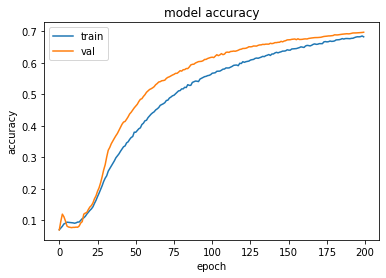

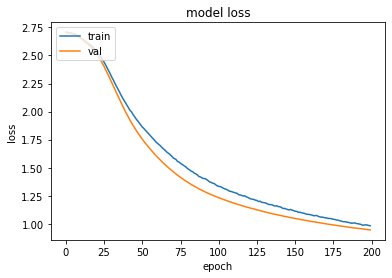

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
results = model.evaluate(test_ds, test_lb)

print(results)

11200/11200 [==============================] - 1s 92us/sample - loss: 0.8948 - acc: 0.7123
[0.8947934932368142, 0.7123214]


In [26]:
predictions = model.predict(test_ds)
cat_tit_dict = get_category_title_dict('data/json/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('data/json/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('data/json/GB_category_id.json'))

In [36]:
from sklearn.metrics import classification_report
print(classification_report(test_lb, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           1       0.84      0.57      0.68       811
           2       0.96      0.88      0.92       790
           3       0.80      0.51      0.62       786
           4       0.98      0.99      0.99       810
           5       0.92      0.79      0.85       806
           6       0.98      0.91      0.94       814
           7       0.86      0.65      0.74       801
           8       0.70      0.34      0.46       798
           9       0.82      0.67      0.74       845
          10       0.20      0.67      0.30       791
          11       0.77      0.67      0.72       772
          12       0.86      0.71      0.78       761
          13       0.88      0.79      0.83       771
          14       0.90      0.80      0.85       844

    accuracy                           0.71     11200
   macro avg       0.82      0.71      0.74     11200
weighted avg       0.82      0.71      0.75     11200



In [29]:
def one_hot_to_index(one_hot):
    i_tags = []
    for i, b in enumerate(one_hot):
        if b == 1.0:
            i_tags.append(i)      
    return i_tags

def index_to_tag(i_tags):
    w_tags = []
    reversed_vocab_dict = {i: vo for vo, i in vocab_di.items()}
    for index in i_tags:
        w_tags.append(reversed_vocab_dict[index])
    return w_tags


In [ ]:
for i in range(0, 20):
#     one_hot = one_hot_to_index(test_ds.values[i])
#     tags_i = index_to_tag(one_hot)
#     print(tags_i)
    print('predict:{}'.format(cat_tit_dict[str(np.argmax(predictions[i]))]))
    print('true label:{}'.format(cat_tit_dict[str(test_lb.values[i])]))

# Classifying using tags, number of likes and number of comments


In [ ]:
full_dataframe = load_dataframe(csvpath, ['tags', 'likes', 'comment_count', 'category_id'])
max_of_tags = 25

full_dataframe = create_seperate_columns(full_dataframe, max_of_tags, 'tags')

full_dataframe.head()